In [72]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

In [74]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
# TODO: Change to second order optimizer.
learning_rate = 0.01
momentum = 0.5
log_interval = 10

mnist_global_mean = 0.1307
mnist_std = 0.3081

random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {} for training".format(device))

Using device cuda for training


In [75]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (mnist_global_mean,), (mnist_std,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [76]:
# TODO: See if setting num_workers > 1 or using pin_memory can help with CPU/GPU transfers.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (mnist_global_mean,), (mnist_std,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [77]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# TODO: By default the backgrounds are black and the text is white; invert this.

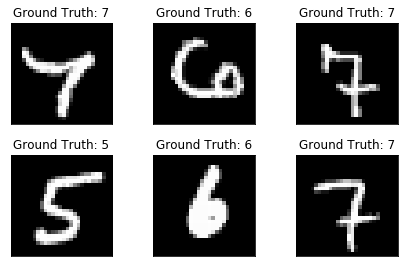

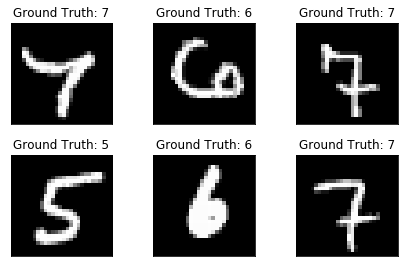

In [78]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [79]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [80]:
network = Net()
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [81]:
train_losses, train_counter, test_losses = [], [], []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [82]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    output = output.to(device)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100.0 * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
      results_path = '../training_results/01b_simple_toy1/'
      torch.save(network.state_dict(), results_path + 'model.pth')
      torch.save(optimizer.state_dict(), results_path + 'optimizer.pth')

In [83]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      output = output.to(device)
      # TODO: Handle the deprecation warning for log_softmax needing an explicit 'dim' argument
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

In [84]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.278280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279819
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.262904
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.256571
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301888
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.189036
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.182645
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.071776
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.033747
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.080227
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.933419
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.735479
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.913359
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.753751
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.448043
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.495531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.326040
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445123
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.298863
Train Epoch: 1 [12160/6

In [85]:
len(train_counter), len(train_losses)

(282, 282)

In [86]:
len(test_counter), len(test_losses)

(4, 4)

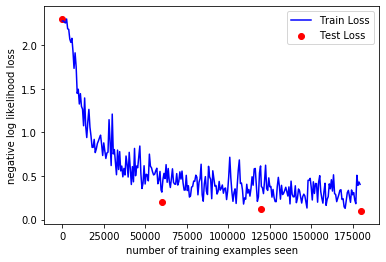

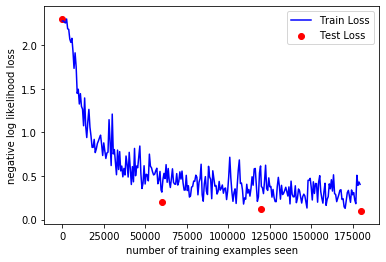

In [87]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig